In [9]:
# Cell 1: Imports and Device Setup
import os
import time
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:

# Cell 2: Color Map and Mask Conversion (Background = index 0)
COLOR_MAP = {
    (0, 0, 0): 0,            # Background to ignore
    (255, 255, 0): 1,        # Crater
    (255, 0, 0): 2,          # Rough
    (0, 255, 0): 3,          # Smooth
    (0, 0, 255): 4           # Alluvial_Fan
}

def mask_to_class(mask: Image.Image) -> np.ndarray:
    """
    Convert an RGB mask image to a 2D array of class indices.
    """
    mask = np.array(mask)
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    for rgb, idx in COLOR_MAP.items():
        class_mask[(mask == rgb).all(axis=-1)] = idx
    return class_mask

In [11]:
# Cell 3: Dataset Definition
class MarsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted([f for f in os.listdir(image_dir) if f.startswith("img_")])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        mask_name = img_name.replace("img_", "mask_")

        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB").resize((256, 256))
        mask_img = Image.open(os.path.join(self.mask_dir, mask_name)).convert("RGB").resize((256, 256))

        if self.transform:
            image = self.transform(image)

        mask = mask_to_class(mask_img)
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask


In [12]:
# Cell 4: Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),  # Scales to [0,1]
])

train_dataset = MarsDataset(
    image_dir=r"D:\u net\new base\train_images",
    mask_dir=r"D:\u net\new base\train_masks",
    transform=transform
)
val_dataset = MarsDataset(
    image_dir=r"D:\u net\new base\val_image",
    mask_dir=r"D:\u net\new base\val_mask",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=8,  shuffle=False, num_workers=0)

In [13]:
# Cell 5: CBAM Blocks and U-Net Definition
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        return self.sigmoid(self.conv1(torch.cat([avg, max_], dim=1)))

class ConvBlockCBAM(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)
        self.ca = ChannelAttention(out_c)
        self.sa = SpatialAttention()
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ConvBlockCBAM(in_c, out_c)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        f = self.conv(x)
        p = self.pool(f)
        return f, p
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
        self.conv = ConvBlockCBAM(out_c*2, out_c)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class CBAMUNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.enc1 = EncoderBlock(3,  64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128,256)
        self.enc4 = EncoderBlock(256,512)
        self.bottleneck = ConvBlockCBAM(512,1024)
        self.dec1 = DecoderBlock(1024,512)
        self.dec2 = DecoderBlock(512,256)
        self.dec3 = DecoderBlock(256,128)
        self.dec4 = DecoderBlock(128,64)
        self.final = nn.Conv2d(64, num_classes, 1)
    def forward(self, x):
        s1,p1 = self.enc1(x)
        s2,p2 = self.enc2(p1)
        s3,p3 = self.enc3(p2)
        s4,p4 = self.enc4(p3)
        b     = self.bottleneck(p4)
        d1    = self.dec1(b,   s4)
        d2    = self.dec2(d1,  s3)
        d3    = self.dec3(d2,  s2)
        d4    = self.dec4(d3,  s1)
        return self.final(d4)

In [14]:
# Define class weights (higher weight for Alluvial_Fan)
class_weights = torch.tensor([0.0, 1.0, 1.0, 1.0, 2.5])  # [background, Crater, Rough, Smooth, Alluvial_Fan]
class_weights = class_weights.to(device)  # Move to GPU if available

# Custom Combined Loss (CrossEntropy + Dice)
class CombinedLoss(nn.Module):
    def __init__(self, weights, smooth=1e-5):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights, ignore_index=0)
        self.smooth = smooth

    def forward(self, pred, target):
        # CrossEntropyLoss
        ce_loss = self.ce(pred, target)
        # DiceLoss
        pred = pred.softmax(dim=1)
        target_one_hot = torch.nn.functional.one_hot(target, pred.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = (pred + target_one_hot).sum(dim=(2, 3))
        dice_loss = 1 - (2 * intersection / (union + self.smooth)).mean()
        return ce_loss + dice_loss  # Combined loss

# Model, Loss, Optimizer, Scheduler
model = CBAMUNet(num_classes=5).to(device)
criterion = CombinedLoss(weights=class_weights)  # Combined loss with class weights [[8]]
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)  # AdamW for regularization [[9]]
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(train_loader)
)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision training [[10]]

C:\Users\HP\AppData\Local\Temp\ipykernel_17168\1265026335.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training [[10]]


In [15]:
# Training Loop with Mixed Precision
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision [[10]]
            outputs = model(imgs)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

# Metric helpers (unchanged)
def compute_confusion_elements(pred, true, class_id):
    pred_i = (pred == class_id)
    true_i = (true == class_id)
    tp = (pred_i & true_i).sum()
    fp = (pred_i & ~true_i).sum()
    fn = (~pred_i & true_i).sum()
    return tp, fp, fn

def eval_one_epoch(model, loader, criterion, device, class_ids):
    model.eval()
    total_loss = 0
    sum_tp = {c:0 for c in class_ids}
    sum_fp = {c:0 for c in class_ids}
    sum_fn = {c:0 for c in class_ids}
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            total_loss += criterion(logits, masks).item()
            preds = torch.argmax(logits, dim=1)
            for c in class_ids:
                tp, fp, fn = compute_confusion_elements(preds, masks, c)
                sum_tp[c] += tp
                sum_fp[c] += fp
                sum_fn[c] += fn
    loss = total_loss / len(loader)
    ious = {c: sum_tp[c] / (sum_tp[c] + sum_fp[c] + sum_fn[c] + 1e-8) for c in class_ids}
    return loss, ious

In [16]:
# Cell 8: Training Loop with Per-Class IoU Logging
num_epochs = 100
best_val_iou = 0.0  # Track best IoU for Alluvial_Fan (class 4)
eval_classes = [1, 2, 3, 4]
class_names = {1:'Crater', 2:'Rough', 3:'Smooth', 4:'Alluvial_Fan'}

for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_ious = eval_one_epoch(model, val_loader, criterion, device, eval_classes)
    scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    for c in eval_classes:
        print(f"    {class_names[c]:15s} IoU: {val_ious[c]:.4f}")

    # Save best model based on Alluvial_Fan IoU
    current_iou = val_ious[4]
    if current_iou > best_val_iou:
        best_val_iou = current_iou
        torch.save(model.state_dict(), "best_mars_segmentation_model.pth")
        print("✅ Saved new best model")

Training:   0%|                                                                                | 0/250 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_17168\1868680471.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision [[10]]


Epoch 1/100
  Train Loss: 2.2147
  Val   Loss: 1.8617
    Crater          IoU: 0.1140
    Rough           IoU: 0.4774
    Smooth          IoU: 0.6420
    Alluvial_Fan    IoU: 0.0989
✅ Saved new best model


Epoch 2/100
  Train Loss: 1.7512
  Val   Loss: 1.5753
    Crater          IoU: 0.1224
    Rough           IoU: 0.4815
    Smooth          IoU: 0.7393
    Alluvial_Fan    IoU: 0.0895


Epoch 3/100
  Train Loss: 1.5145
  Val   Loss: 1.3696
    Crater          IoU: 0.2258
    Rough           IoU: 0.5301
    Smooth          IoU: 0.7493
    Alluvial_Fan    IoU: 0.1118
✅ Saved new best model


Epoch 4/100
  Train Loss: 1.3589
  Val   Loss: 1.2516
    Crater          IoU: 0.3388
    Rough           IoU: 0.5405
    Smooth          IoU: 0.7763
    Alluvial_Fan    IoU: 0.1224
✅ Saved new best model


Epoch 5/100
  Train Loss: 1.2336
  Val   Loss: 1.2222
    Crater          IoU: 0.3470
    Rough           IoU: 0.5614
    Smooth          IoU: 0.7194
    Alluvial_Fan    IoU: 0.1532
✅ Saved new best model


Epoch 6/100
  Train Loss: 1.1545
  Val   Loss: 1.0890
    Crater          IoU: 0.4019
    Rough           IoU: 0.6023
    Smooth          IoU: 0.7904
    Alluvial_Fan    IoU: 0.1610
✅ Saved new best model


Epoch 7/100
  Train Loss: 1.0834
  Val   Loss: 1.0230
    Crater          IoU: 0.5354
    Rough           IoU: 0.6218
    Smooth          IoU: 0.8140
    Alluvial_Fan    IoU: 0.1956
✅ Saved new best model


Epoch 8/100
  Train Loss: 1.0235
  Val   Loss: 0.9812
    Crater          IoU: 0.5353
    Rough           IoU: 0.6567
    Smooth          IoU: 0.8172
    Alluvial_Fan    IoU: 0.2798
✅ Saved new best model


Epoch 9/100
  Train Loss: 0.9751
  Val   Loss: 0.9756
    Crater          IoU: 0.5249
    Rough           IoU: 0.6562
    Smooth          IoU: 0.7652
    Alluvial_Fan    IoU: 0.3104
✅ Saved new best model


Epoch 10/100
  Train Loss: 0.9375
  Val   Loss: 0.9153
    Crater          IoU: 0.6608
    Rough           IoU: 0.6970
    Smooth          IoU: 0.8365
    Alluvial_Fan    IoU: 0.2302


Epoch 11/100
  Train Loss: 0.9131
  Val   Loss: 0.9023
    Crater          IoU: 0.5277
    Rough           IoU: 0.6180
    Smooth          IoU: 0.8369
    Alluvial_Fan    IoU: 0.2498


Epoch 12/100
  Train Loss: 0.8669
  Val   Loss: 0.8591
    Crater          IoU: 0.6665
    Rough           IoU: 0.6949
    Smooth          IoU: 0.8413
    Alluvial_Fan    IoU: 0.2145


Epoch 13/100
  Train Loss: 0.8290
  Val   Loss: 0.8144
    Crater          IoU: 0.7004
    Rough           IoU: 0.7048
    Smooth          IoU: 0.8694
    Alluvial_Fan    IoU: 0.3289
✅ Saved new best model


Epoch 14/100
  Train Loss: 0.8038
  Val   Loss: 0.8004
    Crater          IoU: 0.7317
    Rough           IoU: 0.6983
    Smooth          IoU: 0.8581
    Alluvial_Fan    IoU: 0.3345
✅ Saved new best model


Epoch 15/100
  Train Loss: 0.7874
  Val   Loss: 0.7822
    Crater          IoU: 0.7346
    Rough           IoU: 0.7567
    Smooth          IoU: 0.8767
    Alluvial_Fan    IoU: 0.4384
✅ Saved new best model


Epoch 16/100
  Train Loss: 0.7602
  Val   Loss: 0.7746
    Crater          IoU: 0.6730
    Rough           IoU: 0.7090
    Smooth          IoU: 0.8666
    Alluvial_Fan    IoU: 0.3643


Epoch 17/100
  Train Loss: 0.7273
  Val   Loss: 0.7456
    Crater          IoU: 0.7456
    Rough           IoU: 0.7582
    Smooth          IoU: 0.8812
    Alluvial_Fan    IoU: 0.4245


Epoch 18/100
  Train Loss: 0.7090
  Val   Loss: 0.7167
    Crater          IoU: 0.7278
    Rough           IoU: 0.7785
    Smooth          IoU: 0.8739
    Alluvial_Fan    IoU: 0.4232


Epoch 19/100
  Train Loss: 0.6837
  Val   Loss: 0.7019
    Crater          IoU: 0.7433
    Rough           IoU: 0.7896
    Smooth          IoU: 0.8818
    Alluvial_Fan    IoU: 0.5056
✅ Saved new best model


Epoch 20/100
  Train Loss: 0.6557
  Val   Loss: 0.6819
    Crater          IoU: 0.7926
    Rough           IoU: 0.7908
    Smooth          IoU: 0.8887
    Alluvial_Fan    IoU: 0.4682


Epoch 21/100
  Train Loss: 0.6375
  Val   Loss: 0.6729
    Crater          IoU: 0.8141
    Rough           IoU: 0.7818
    Smooth          IoU: 0.9001
    Alluvial_Fan    IoU: 0.4749


Epoch 22/100
  Train Loss: 0.6178
  Val   Loss: 0.6659
    Crater          IoU: 0.7918
    Rough           IoU: 0.7840
    Smooth          IoU: 0.8969
    Alluvial_Fan    IoU: 0.3925


Epoch 23/100
  Train Loss: 0.6083
  Val   Loss: 0.6538
    Crater          IoU: 0.8145
    Rough           IoU: 0.8037
    Smooth          IoU: 0.8935
    Alluvial_Fan    IoU: 0.4853


Epoch 24/100
  Train Loss: 0.6307
  Val   Loss: 0.6505
    Crater          IoU: 0.8101
    Rough           IoU: 0.8031
    Smooth          IoU: 0.8933
    Alluvial_Fan    IoU: 0.5464
✅ Saved new best model


Epoch 25/100
  Train Loss: 0.5869
  Val   Loss: 0.6457
    Crater          IoU: 0.8225
    Rough           IoU: 0.8182
    Smooth          IoU: 0.9065
    Alluvial_Fan    IoU: 0.5281


Epoch 26/100
  Train Loss: 0.5628
  Val   Loss: 0.6563
    Crater          IoU: 0.8407
    Rough           IoU: 0.8025
    Smooth          IoU: 0.9092
    Alluvial_Fan    IoU: 0.5980
✅ Saved new best model


Epoch 27/100
  Train Loss: 0.5483
  Val   Loss: 0.6099
    Crater          IoU: 0.8455
    Rough           IoU: 0.8210
    Smooth          IoU: 0.9154
    Alluvial_Fan    IoU: 0.5399


Epoch 28/100
  Train Loss: 0.5736
  Val   Loss: 0.6331
    Crater          IoU: 0.8211
    Rough           IoU: 0.8107
    Smooth          IoU: 0.8953
    Alluvial_Fan    IoU: 0.5420


Epoch 29/100
  Train Loss: 0.5437
  Val   Loss: 0.6164
    Crater          IoU: 0.8101
    Rough           IoU: 0.8130
    Smooth          IoU: 0.9092
    Alluvial_Fan    IoU: 0.5772


Epoch 30/100
  Train Loss: 0.5229
  Val   Loss: 0.6001
    Crater          IoU: 0.8514
    Rough           IoU: 0.8307
    Smooth          IoU: 0.9164
    Alluvial_Fan    IoU: 0.5835


Epoch 31/100
  Train Loss: 0.5631
  Val   Loss: 0.7220
    Crater          IoU: 0.7596
    Rough           IoU: 0.7793
    Smooth          IoU: 0.7623
    Alluvial_Fan    IoU: 0.4818


Epoch 32/100
  Train Loss: 0.5744
  Val   Loss: 0.6097
    Crater          IoU: 0.8401
    Rough           IoU: 0.8116
    Smooth          IoU: 0.9139
    Alluvial_Fan    IoU: 0.5990
✅ Saved new best model


Epoch 33/100
  Train Loss: 0.5102
  Val   Loss: 0.5846
    Crater          IoU: 0.8537
    Rough           IoU: 0.8354
    Smooth          IoU: 0.9232
    Alluvial_Fan    IoU: 0.5946


Epoch 34/100
  Train Loss: 0.4929
  Val   Loss: 0.5954
    Crater          IoU: 0.8604
    Rough           IoU: 0.8365
    Smooth          IoU: 0.9236
    Alluvial_Fan    IoU: 0.6302
✅ Saved new best model


Epoch 35/100
  Train Loss: 0.4896
  Val   Loss: 0.5815
    Crater          IoU: 0.8684
    Rough           IoU: 0.8433
    Smooth          IoU: 0.9219
    Alluvial_Fan    IoU: 0.6262


Epoch 36/100
  Train Loss: 0.4893
  Val   Loss: 0.5915
    Crater          IoU: 0.8641
    Rough           IoU: 0.8450
    Smooth          IoU: 0.9229
    Alluvial_Fan    IoU: 0.6454
✅ Saved new best model


Epoch 37/100
  Train Loss: 0.4866
  Val   Loss: 0.6042
    Crater          IoU: 0.8640
    Rough           IoU: 0.8430
    Smooth          IoU: 0.9199
    Alluvial_Fan    IoU: 0.6515
✅ Saved new best model


Epoch 38/100
  Train Loss: 0.5147
  Val   Loss: 0.5891
    Crater          IoU: 0.8444
    Rough           IoU: 0.8386
    Smooth          IoU: 0.9210
    Alluvial_Fan    IoU: 0.6037


Epoch 39/100
  Train Loss: 0.4774
  Val   Loss: 0.5828
    Crater          IoU: 0.8613
    Rough           IoU: 0.8409
    Smooth          IoU: 0.9270
    Alluvial_Fan    IoU: 0.6578
✅ Saved new best model


Epoch 40/100
  Train Loss: 0.4669
  Val   Loss: 0.5811
    Crater          IoU: 0.8534
    Rough           IoU: 0.8513
    Smooth          IoU: 0.9252
    Alluvial_Fan    IoU: 0.6370


Epoch 41/100
  Train Loss: 0.4617
  Val   Loss: 0.5979
    Crater          IoU: 0.8678
    Rough           IoU: 0.8478
    Smooth          IoU: 0.9289
    Alluvial_Fan    IoU: 0.6873
✅ Saved new best model


Epoch 42/100
  Train Loss: 0.4576
  Val   Loss: 0.5830
    Crater          IoU: 0.8607
    Rough           IoU: 0.8417
    Smooth          IoU: 0.9229
    Alluvial_Fan    IoU: 0.6703


Epoch 43/100
  Train Loss: 0.4564
  Val   Loss: 0.5783
    Crater          IoU: 0.8604
    Rough           IoU: 0.8447
    Smooth          IoU: 0.9297
    Alluvial_Fan    IoU: 0.6812


Epoch 44/100
  Train Loss: 0.4528
  Val   Loss: 0.5940
    Crater          IoU: 0.8656
    Rough           IoU: 0.8459
    Smooth          IoU: 0.9254
    Alluvial_Fan    IoU: 0.6640


Epoch 45/100
  Train Loss: 0.4493
  Val   Loss: 0.5859
    Crater          IoU: 0.8614
    Rough           IoU: 0.8458
    Smooth          IoU: 0.9303
    Alluvial_Fan    IoU: 0.6901
✅ Saved new best model


Epoch 46/100
  Train Loss: 0.4465
  Val   Loss: 0.5871
    Crater          IoU: 0.8770
    Rough           IoU: 0.8555
    Smooth          IoU: 0.9306
    Alluvial_Fan    IoU: 0.6986
✅ Saved new best model


Epoch 47/100
  Train Loss: 0.4441
  Val   Loss: 0.5838
    Crater          IoU: 0.8685
    Rough           IoU: 0.8534
    Smooth          IoU: 0.9287
    Alluvial_Fan    IoU: 0.7002
✅ Saved new best model


Epoch 48/100
  Train Loss: 0.4401
  Val   Loss: 0.5856
    Crater          IoU: 0.8645
    Rough           IoU: 0.8557
    Smooth          IoU: 0.9298
    Alluvial_Fan    IoU: 0.6951


Epoch 49/100
  Train Loss: 0.4376
  Val   Loss: 0.5804
    Crater          IoU: 0.8689
    Rough           IoU: 0.8501
    Smooth          IoU: 0.9301
    Alluvial_Fan    IoU: 0.6965


Epoch 50/100
  Train Loss: 0.4338
  Val   Loss: 0.5945
    Crater          IoU: 0.8729
    Rough           IoU: 0.8528
    Smooth          IoU: 0.9299
    Alluvial_Fan    IoU: 0.7188
✅ Saved new best model


Epoch 51/100
  Train Loss: 0.4485
  Val   Loss: 0.6167
    Crater          IoU: 0.8635
    Rough           IoU: 0.8437
    Smooth          IoU: 0.9148
    Alluvial_Fan    IoU: 0.6419


Epoch 52/100
  Train Loss: 0.4402
  Val   Loss: 0.5897
    Crater          IoU: 0.8762
    Rough           IoU: 0.8595
    Smooth          IoU: 0.9334
    Alluvial_Fan    IoU: 0.7177


Epoch 53/100
  Train Loss: 0.4279
  Val   Loss: 0.5702
    Crater          IoU: 0.8764
    Rough           IoU: 0.8553
    Smooth          IoU: 0.9331
    Alluvial_Fan    IoU: 0.6960


Epoch 54/100
  Train Loss: 0.4323
  Val   Loss: 0.5784
    Crater          IoU: 0.8651
    Rough           IoU: 0.8558
    Smooth          IoU: 0.9279
    Alluvial_Fan    IoU: 0.6952


Epoch 55/100
  Train Loss: 0.4359
  Val   Loss: 0.6426
    Crater          IoU: 0.8618
    Rough           IoU: 0.8389
    Smooth          IoU: 0.9164
    Alluvial_Fan    IoU: 0.6996


Epoch 56/100
  Train Loss: 0.4375
  Val   Loss: 0.5815
    Crater          IoU: 0.8733
    Rough           IoU: 0.8552
    Smooth          IoU: 0.9332
    Alluvial_Fan    IoU: 0.7062


Epoch 57/100
  Train Loss: 0.4227
  Val   Loss: 0.5730
    Crater          IoU: 0.8843
    Rough           IoU: 0.8601
    Smooth          IoU: 0.9359
    Alluvial_Fan    IoU: 0.7201
✅ Saved new best model


Epoch 58/100
  Train Loss: 0.4172
  Val   Loss: 0.5759
    Crater          IoU: 0.8795
    Rough           IoU: 0.8589
    Smooth          IoU: 0.9358
    Alluvial_Fan    IoU: 0.7241
✅ Saved new best model


Epoch 59/100
  Train Loss: 0.4464
  Val   Loss: 0.8152
    Crater          IoU: 0.7236
    Rough           IoU: 0.7388
    Smooth          IoU: 0.8402
    Alluvial_Fan    IoU: 0.4032


Epoch 60/100
  Train Loss: 0.4718
  Val   Loss: 0.5638
    Crater          IoU: 0.8772
    Rough           IoU: 0.8613
    Smooth          IoU: 0.9312
    Alluvial_Fan    IoU: 0.6985


Epoch 61/100
  Train Loss: 0.4201
  Val   Loss: 0.5647
    Crater          IoU: 0.8802
    Rough           IoU: 0.8610
    Smooth          IoU: 0.9337
    Alluvial_Fan    IoU: 0.7244
✅ Saved new best model


Epoch 62/100
  Train Loss: 0.4122
  Val   Loss: 0.5744
    Crater          IoU: 0.8874
    Rough           IoU: 0.8640
    Smooth          IoU: 0.9342
    Alluvial_Fan    IoU: 0.7347
✅ Saved new best model


Epoch 63/100
  Train Loss: 0.4091
  Val   Loss: 0.5775
    Crater          IoU: 0.8696
    Rough           IoU: 0.8643
    Smooth          IoU: 0.9358
    Alluvial_Fan    IoU: 0.7324


Epoch 64/100
  Train Loss: 0.4070
  Val   Loss: 0.5813
    Crater          IoU: 0.8842
    Rough           IoU: 0.8669
    Smooth          IoU: 0.9354
    Alluvial_Fan    IoU: 0.7408
✅ Saved new best model


Epoch 65/100
  Train Loss: 0.4049
  Val   Loss: 0.6000
    Crater          IoU: 0.8847
    Rough           IoU: 0.8637
    Smooth          IoU: 0.9311
    Alluvial_Fan    IoU: 0.7406


Epoch 66/100
  Train Loss: 0.4085
  Val   Loss: 0.5885
    Crater          IoU: 0.8838
    Rough           IoU: 0.8655
    Smooth          IoU: 0.9354
    Alluvial_Fan    IoU: 0.7476
✅ Saved new best model


Epoch 67/100
  Train Loss: 0.4047
  Val   Loss: 0.5804
    Crater          IoU: 0.8787
    Rough           IoU: 0.8601
    Smooth          IoU: 0.9353
    Alluvial_Fan    IoU: 0.7359


Epoch 68/100
  Train Loss: 0.4042
  Val   Loss: 0.5968
    Crater          IoU: 0.8823
    Rough           IoU: 0.8656
    Smooth          IoU: 0.9334
    Alluvial_Fan    IoU: 0.7509
✅ Saved new best model


Epoch 69/100
  Train Loss: 0.4052
  Val   Loss: 0.5789
    Crater          IoU: 0.8829
    Rough           IoU: 0.8648
    Smooth          IoU: 0.9361
    Alluvial_Fan    IoU: 0.7406


Epoch 70/100
  Train Loss: 0.4077
  Val   Loss: 0.5758
    Crater          IoU: 0.8797
    Rough           IoU: 0.8601
    Smooth          IoU: 0.9339
    Alluvial_Fan    IoU: 0.7175


Epoch 71/100
  Train Loss: 0.4063
  Val   Loss: 0.5854
    Crater          IoU: 0.8772
    Rough           IoU: 0.8564
    Smooth          IoU: 0.9368
    Alluvial_Fan    IoU: 0.7329


Epoch 72/100
  Train Loss: 0.4076
  Val   Loss: 0.5868
    Crater          IoU: 0.8835
    Rough           IoU: 0.8656
    Smooth          IoU: 0.9331
    Alluvial_Fan    IoU: 0.7418


Epoch 73/100
  Train Loss: 0.4020
  Val   Loss: 0.5815
    Crater          IoU: 0.8865
    Rough           IoU: 0.8701
    Smooth          IoU: 0.9384
    Alluvial_Fan    IoU: 0.7521
✅ Saved new best model


Epoch 74/100
  Train Loss: 0.3997
  Val   Loss: 0.5729
    Crater          IoU: 0.8875
    Rough           IoU: 0.8667
    Smooth          IoU: 0.9354
    Alluvial_Fan    IoU: 0.7413


Epoch 75/100
  Train Loss: 0.3989
  Val   Loss: 0.5845
    Crater          IoU: 0.8861
    Rough           IoU: 0.8665
    Smooth          IoU: 0.9384
    Alluvial_Fan    IoU: 0.7454


Epoch 76/100
  Train Loss: 0.3993
  Val   Loss: 0.5888
    Crater          IoU: 0.8753
    Rough           IoU: 0.8634
    Smooth          IoU: 0.9342
    Alluvial_Fan    IoU: 0.7172


Epoch 77/100
  Train Loss: 0.4058
  Val   Loss: 0.5767
    Crater          IoU: 0.8828
    Rough           IoU: 0.8638
    Smooth          IoU: 0.9381
    Alluvial_Fan    IoU: 0.7354


Epoch 78/100
  Train Loss: 0.3978
  Val   Loss: 0.5727
    Crater          IoU: 0.8835
    Rough           IoU: 0.8645
    Smooth          IoU: 0.9382
    Alluvial_Fan    IoU: 0.7448


Epoch 79/100
  Train Loss: 0.3993
  Val   Loss: 0.5817
    Crater          IoU: 0.8732
    Rough           IoU: 0.8616
    Smooth          IoU: 0.9351
    Alluvial_Fan    IoU: 0.7287


Epoch 80/100
  Train Loss: 0.3974
  Val   Loss: 0.5762
    Crater          IoU: 0.8790
    Rough           IoU: 0.8700
    Smooth          IoU: 0.9376
    Alluvial_Fan    IoU: 0.7486


Epoch 81/100
  Train Loss: 0.3958
  Val   Loss: 0.5893
    Crater          IoU: 0.8791
    Rough           IoU: 0.8607
    Smooth          IoU: 0.9335
    Alluvial_Fan    IoU: 0.7425


Epoch 82/100
  Train Loss: 0.3974
  Val   Loss: 0.5927
    Crater          IoU: 0.8760
    Rough           IoU: 0.8425
    Smooth          IoU: 0.9264
    Alluvial_Fan    IoU: 0.7089


Epoch 83/100
  Train Loss: 0.4105
  Val   Loss: 0.5972
    Crater          IoU: 0.8861
    Rough           IoU: 0.8662
    Smooth          IoU: 0.9341
    Alluvial_Fan    IoU: 0.7369


Epoch 84/100
  Train Loss: 0.3966
  Val   Loss: 0.5715
    Crater          IoU: 0.8925
    Rough           IoU: 0.8684
    Smooth          IoU: 0.9389
    Alluvial_Fan    IoU: 0.7554
✅ Saved new best model


Epoch 85/100
  Train Loss: 0.3880
  Val   Loss: 0.5780
    Crater          IoU: 0.8895
    Rough           IoU: 0.8723
    Smooth          IoU: 0.9403
    Alluvial_Fan    IoU: 0.7589
✅ Saved new best model


Epoch 86/100
  Train Loss: 0.3864
  Val   Loss: 0.5763
    Crater          IoU: 0.8884
    Rough           IoU: 0.8707
    Smooth          IoU: 0.9391
    Alluvial_Fan    IoU: 0.7592
✅ Saved new best model


Epoch 87/100
  Train Loss: 0.3900
  Val   Loss: 0.6409
    Crater          IoU: 0.8691
    Rough           IoU: 0.8427
    Smooth          IoU: 0.9220
    Alluvial_Fan    IoU: 0.7312


Epoch 88/100
  Train Loss: 0.4062
  Val   Loss: 0.5734
    Crater          IoU: 0.8861
    Rough           IoU: 0.8666
    Smooth          IoU: 0.9375
    Alluvial_Fan    IoU: 0.7462


Epoch 89/100
  Train Loss: 0.3891
  Val   Loss: 0.5806
    Crater          IoU: 0.8883
    Rough           IoU: 0.8695
    Smooth          IoU: 0.9395
    Alluvial_Fan    IoU: 0.7591


Epoch 90/100
  Train Loss: 0.3850
  Val   Loss: 0.5880
    Crater          IoU: 0.8869
    Rough           IoU: 0.8702
    Smooth          IoU: 0.9390
    Alluvial_Fan    IoU: 0.7629
✅ Saved new best model


Epoch 91/100
  Train Loss: 0.3835
  Val   Loss: 0.5759
    Crater          IoU: 0.8904
    Rough           IoU: 0.8734
    Smooth          IoU: 0.9402
    Alluvial_Fan    IoU: 0.7662
✅ Saved new best model


Epoch 92/100
  Train Loss: 0.3830
  Val   Loss: 0.5845
    Crater          IoU: 0.8881
    Rough           IoU: 0.8693
    Smooth          IoU: 0.9394
    Alluvial_Fan    IoU: 0.7674
✅ Saved new best model


Epoch 93/100
  Train Loss: 0.3827
  Val   Loss: 0.6030
    Crater          IoU: 0.8932
    Rough           IoU: 0.8725
    Smooth          IoU: 0.9414
    Alluvial_Fan    IoU: 0.7727
✅ Saved new best model


Epoch 94/100
  Train Loss: 0.3842
  Val   Loss: 0.6016
    Crater          IoU: 0.8879
    Rough           IoU: 0.8686
    Smooth          IoU: 0.9376
    Alluvial_Fan    IoU: 0.7638


Epoch 95/100
  Train Loss: 0.3839
  Val   Loss: 0.5882
    Crater          IoU: 0.8844
    Rough           IoU: 0.8688
    Smooth          IoU: 0.9365
    Alluvial_Fan    IoU: 0.7591


Epoch 96/100
  Train Loss: 0.3829
  Val   Loss: 0.5774
    Crater          IoU: 0.8891
    Rough           IoU: 0.8725
    Smooth          IoU: 0.9390
    Alluvial_Fan    IoU: 0.7557


Epoch 97/100
  Train Loss: 0.3842
  Val   Loss: 0.5853
    Crater          IoU: 0.8885
    Rough           IoU: 0.8715
    Smooth          IoU: 0.9402
    Alluvial_Fan    IoU: 0.7597


Epoch 98/100
  Train Loss: 0.3824
  Val   Loss: 0.5817
    Crater          IoU: 0.8905
    Rough           IoU: 0.8725
    Smooth          IoU: 0.9399
    Alluvial_Fan    IoU: 0.7663


Epoch 99/100
  Train Loss: 0.3821
  Val   Loss: 0.5887
    Crater          IoU: 0.8900
    Rough           IoU: 0.8707
    Smooth          IoU: 0.9389
    Alluvial_Fan    IoU: 0.7627


Epoch 100/100
  Train Loss: 0.3814
  Val   Loss: 0.5712
    Crater          IoU: 0.8905
    Rough           IoU: 0.8715
    Smooth          IoU: 0.9401
    Alluvial_Fan    IoU: 0.7526


In [22]:
# Cell 9: Full Validation Metrics (IoU, Dice, Precision, Recall, Loss, Inference Time)

import time
import numpy as np
import torch

# --- 1. Metric definitions ---
def compute_confusion_elements(pred, true, class_id):
    pred_i = (pred == class_id)
    true_i = (true == class_id)
    tp = np.logical_and(pred_i, true_i).sum()
    fp = np.logical_and(pred_i, ~true_i).sum()
    fn = np.logical_and(~pred_i, true_i).sum()
    return tp, fp, fn

def compute_iou(tp, fp, fn):
    return tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

def compute_dice(tp, fp, fn):
    return 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0

def compute_precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def compute_recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

# --- 2. Evaluation loop ---
def evaluate_model(model, dataloader, criterion, num_classes=5, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_time = 0.0
    total_samples = 0

    # accumulators per class
    sum_tp = np.zeros(num_classes, dtype=np.int64)
    sum_fp = np.zeros(num_classes, dtype=np.int64)
    sum_fn = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # time the forward pass
            torch.cuda.synchronize() if device != 'cpu' else None
            t0 = time.time()
            logits = model(imgs)
            torch.cuda.synchronize() if device != 'cpu' else None
            t1 = time.time()

            batch_size = imgs.size(0)
            total_time += (t1 - t0) * batch_size
            total_samples += batch_size

            # accumulate loss
            loss = criterion(logits, masks)
            total_loss += loss.item() * batch_size

            # predictions & truths to numpy
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            trues = masks.cpu().numpy()

            # accumulate confusion matrix elements
            for c in range(num_classes):
                for p, t in zip(preds, trues):
                    tp, fp, fn = compute_confusion_elements(p, t, c)
                    sum_tp[c] += tp
                    sum_fp[c] += fp
                    sum_fn[c] += fn

    # compute per-class metrics
    ious = [compute_iou(sum_tp[c], sum_fp[c], sum_fn[c]) for c in range(num_classes)]
    dices = [compute_dice(sum_tp[c], sum_fp[c], sum_fn[c]) for c in range(num_classes)]
    precs = [compute_precision(sum_tp[c], sum_fp[c]) for c in range(num_classes)]
    recs  = [compute_recall(sum_tp[c], sum_fn[c]) for c in range(num_classes)]

    return {
        'IoU_per_class': ious,
        'Mean_IoU': np.mean(ious),
        'Dice_per_class': dices,
        'Mean_Dice': np.mean(dices),
        'Precision_per_class': precs,
        'Mean_Precision': np.mean(precs),
        'Recall_per_class': recs,
        'Mean_Recall': np.mean(recs),
        'Avg_Loss': total_loss / total_samples,
        'Avg_Inference_Time_per_Image': total_time / total_samples
    }

# --- 3. Load best model (optional) ---
best_model = CBAMUNet(num_classes=5).to(device)
best_model.load_state_dict(torch.load(r"D:\u net\best_mars_segmentation_model.pth"))
best_model.eval()

# --- 4. Run evaluation ---
metrics = evaluate_model(best_model, val_loader, criterion, num_classes=5, device=device)

# --- 5. Display results ---
print("\n=== Validation Metrics ===")
for cls_id, name in class_names.items():
    print(f"{name:15s} | IoU: {metrics['IoU_per_class'][cls_id]:.4f} "
          f"| Dice: {metrics['Dice_per_class'][cls_id]:.4f} "
          f"| Precision: {metrics['Precision_per_class'][cls_id]:.4f} "
          f"| Recall: {metrics['Recall_per_class'][cls_id]:.4f}")
print(f"\nMean IoU:       {metrics['Mean_IoU']:.4f}")
print(f"Mean Dice:      {metrics['Mean_Dice']:.4f}")
print(f"Mean Precision: {metrics['Mean_Precision']:.4f}")
print(f"Mean Recall:    {metrics['Mean_Recall']:.4f}")
print(f"Avg Loss:       {metrics['Avg_Loss']:.4f}")
print(f"Avg Inference Time per Image: {metrics['Avg_Inference_Time_per_Image']*1000:.2f} ms")


C:\Users\HP\AppData\Local\Temp\ipykernel_17168\2361042326.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(r"D:\u net\best_mars_seg


=== Validation Metrics ===
Crater          | IoU: 0.8932 | Dice: 0.9436 | Precision: 0.9395 | Recall: 0.9477
Rough           | IoU: 0.8725 | Dice: 0.9319 | Precision: 0.9127 | Recall: 0.9520
Smooth          | IoU: 0.9414 | Dice: 0.9698 | Precision: 0.9580 | Recall: 0.9820
Alluvial_Fan    | IoU: 0.7727 | Dice: 0.8718 | Precision: 0.8359 | Recall: 0.9109

Mean IoU:       0.8698
Mean Dice:      0.9294
Mean Precision: 0.9213
Mean Recall:    0.9388
Avg Loss:       0.1677
Avg Inference Time per Image: 160.53 ms


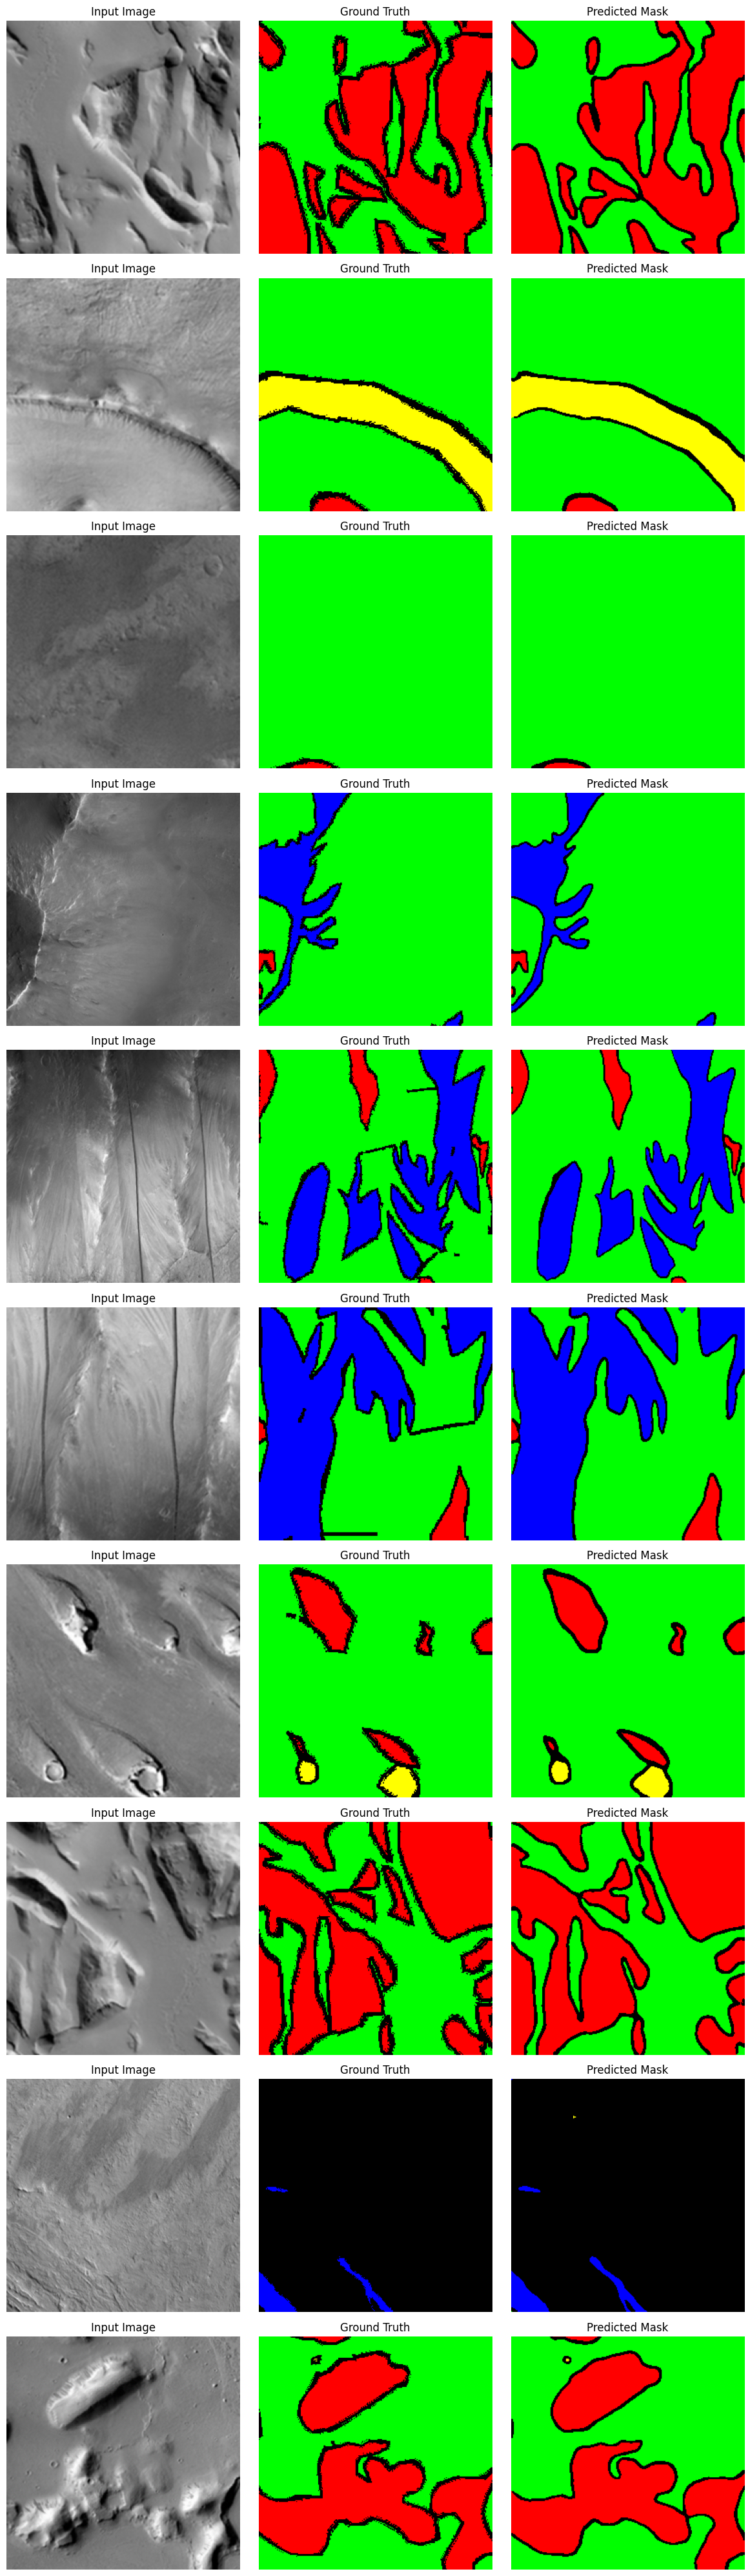

In [23]:
# Cell 10: Visualize Input | Ground Truth | Predicted Mask

import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Make sure your CBAMUNet model is loaded and on eval mode
model.eval()

# A helper to map class indices back to RGB for display
INV_COLOR_MAP = {v:k for k,v in COLOR_MAP.items()}

def class_to_rgb(mask):
    """
    mask: 2D numpy array of class indices
    returns: HxWx3 RGB image
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in INV_COLOR_MAP.items():
        rgb[(mask == cls)] = color
    return rgb

def visualize_random_samples(dataset, model, device, n_samples=4):
    """
    Picks n_samples random items from dataset, runs model, and plots.
    """
    indices = random.sample(range(len(dataset)), n_samples)
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))
    
    for row, idx in enumerate(indices):
        # load image & gt
        img_tensor, gt_mask = dataset[idx]
        img = img_tensor.permute(1,2,0).numpy()      # HWC, [0,1]
        gt_mask = gt_mask.numpy()                    # HxW ints
        
        # model prediction
        with torch.no_grad():
            inp = img_tensor.unsqueeze(0).to(device)
            logits = model(inp)
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
        
        # convert masks to RGB for display
        gt_rgb   = class_to_rgb(gt_mask)
        pred_rgb = class_to_rgb(pred)
        
        # plot
        axes[row,0].imshow(img)
        axes[row,0].set_title("Input Image")
        axes[row,0].axis('off')
        
        axes[row,1].imshow(gt_rgb)
        axes[row,1].set_title("Ground Truth")
        axes[row,1].axis('off')
        
        axes[row,2].imshow(pred_rgb)
        axes[row,2].set_title("Predicted Mask")
        axes[row,2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run it:
visualize_random_samples(train_dataset, model, device, n_samples=10)


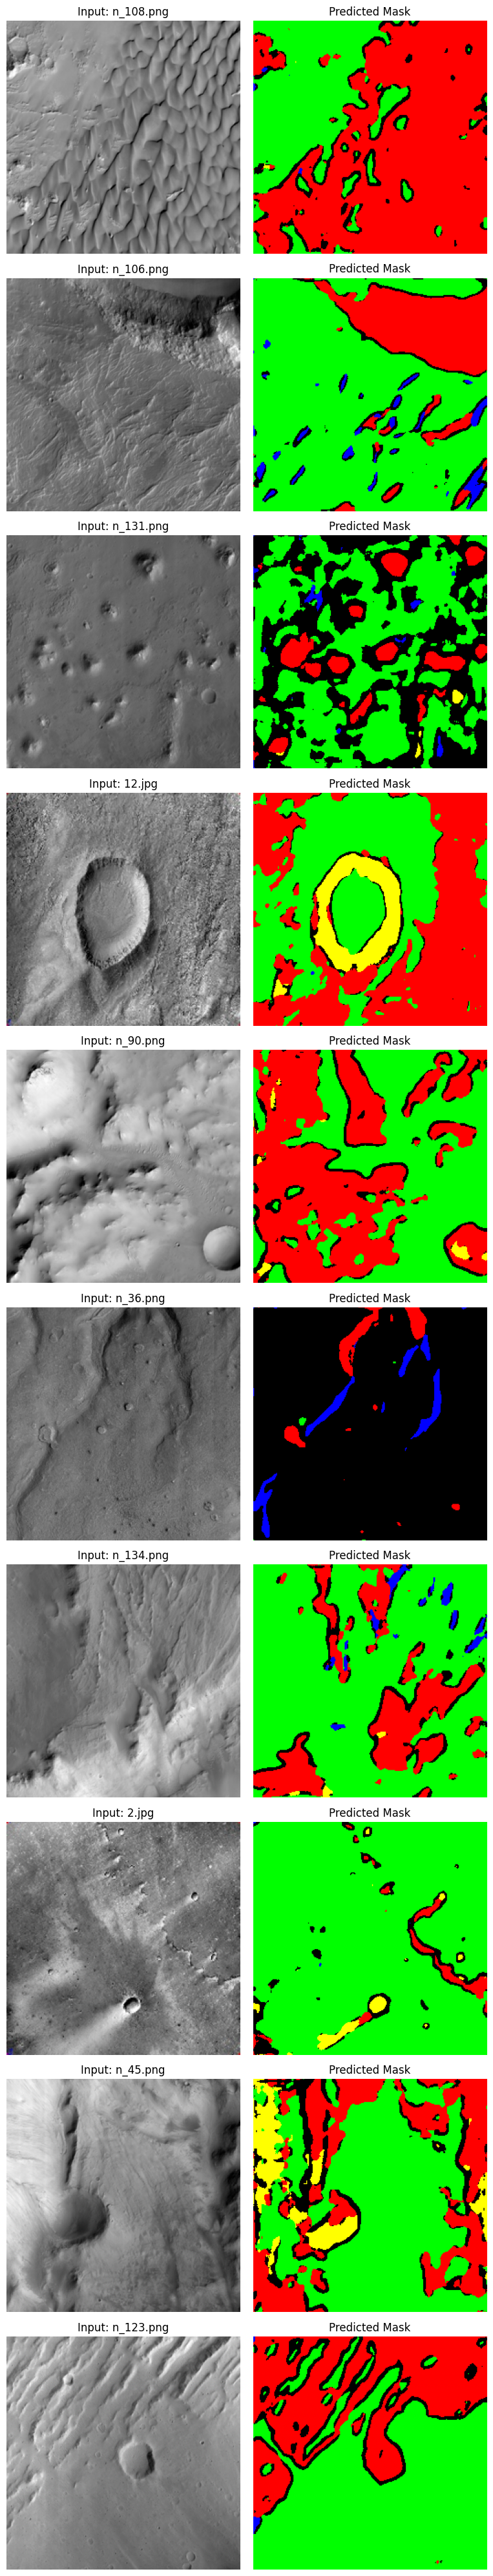

In [26]:
# Cell 11: Visualize Test Images | Predicted Mask

import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# --- 1. Setup ---
test_image_dir = r"D:\u net\new base\test images" # adjust to your test folder
file_names = [f for f in os.listdir(test_image_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]

# reuse the inverse color map from before
INV_COLOR_MAP = {v:k for k,v in COLOR_MAP.items()}

def class_to_rgb(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in INV_COLOR_MAP.items():
        rgb[mask == cls] = color
    return rgb

# image transform (must match training)
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

# --- 2. Visualization function ---
def visualize_test_predictions(model, device, n_samples=4):
    model.eval()
    samples = random.sample(file_names, n_samples)
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 4*n_samples))
    for i, fname in enumerate(samples):
        # load and preprocess image
        path = os.path.join(test_image_dir, fname)
        img_pil = Image.open(path).convert("RGB")
        img_resized = img_pil.resize((256,256))
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        
        # forward pass
        with torch.no_grad():
            logits = model(img_tensor)
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
        
        # to display
        img_np = np.array(img_resized)
        pred_rgb = class_to_rgb(pred)
        
        # plot
        axes[i,0].imshow(img_np)
        axes[i,0].set_title(f"Input: {fname}")
        axes[i,0].axis('off')
        
        axes[i,1].imshow(pred_rgb)
        axes[i,1].set_title("Predicted Mask")
        axes[i,1].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- 3. Run it ---
visualize_test_predictions(model, device, n_samples=10)
